# More calculations

By now we have been only calculating properties "on point", but we can do
more than that with `yaeos`. Here we have a few examples:

## Calculating an isotherm

Let's create a plot Pressure vs Volume at a given temperature (250 K) for a
pure component. Let's use carbon dioxide.

Text(0, 0.5, 'Pressure [bar]')

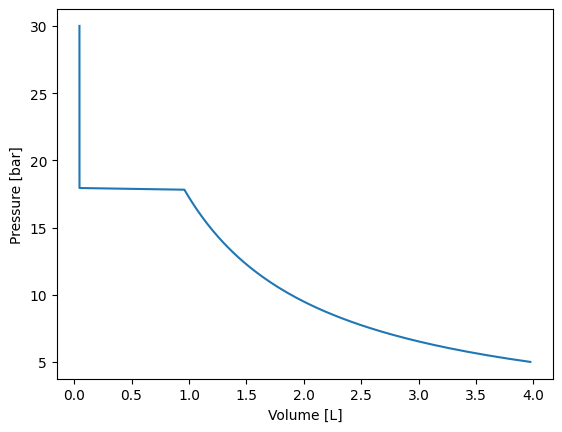

In [1]:
from yaeos import SoaveRedlichKwong
import numpy as np
import matplotlib.pyplot as plt

n = [1.0]  # mole number of CO2 [mol]
Tc = [304.2]  # critical temperature of CO2 [K]
Pc = [73.8]  # critical pressure of CO2 [bar]
w = [0.2236]  # acentric factor of CO2 [-]

# Instantiate a Soave-Redlich-Kwong equation of state model
model = SoaveRedlichKwong(Tc, Pc, w)

# Calculate isotherm at 250 K
t = 250  # K

# pressures list (200 pressure points between 5 and 30 bar)
pressures = np.linspace(5, 30, 200)

# list to store the calculated volumes
volumes = []

for p in pressures:
    # Calculate volume for each pressure
    volume = model.volume(n, p, t, root="stable")
    volumes.append(volume)

# Make plot
plt.plot(volumes, pressures)
plt.xlabel("Volume [L]")
plt.ylabel("Pressure [bar]")

## Calculate a saturation pressure
### Pure compound

In the previous example we obtained an isotherm for carbon dioxide at 250 K. We
can check in the plot that the saturation pressure is around 18 bar. Let's
calculate the previous saturation pressure using `yaeos` and the instantiated
`model`.


In [2]:
sat_point = model.saturation_pressure(z=[1.0], temperature=250.0)

sat_point

{'x': array([1.]),
 'y': array([1.00001087]),
 'Vx': 0.046689498895265885,
 'Vy': 0.953487212716271,
 'T': 250.0,
 'P': 17.916706378791627,
 'beta': 0.0}

There we obtained a Python dictionary with the result of the saturation
pressure calculation. In this example we have a pure compound (CO2), so we are
only interested in the `P` result (the saturation pressure).

In [3]:
print(sat_point["P"], " bar")

17.916706378791627  bar


The DIPPR correlated value for the saturation pressure of CO2 at 250 K is 17.88
bar, so SoaveRedlichKwong is doing a good job in this case.

### Mixture

Of course, in thermodynamics there is not only pure compounds, we can also
use `yaeos` to calculate the saturation pressure of a mixture. Let's calculate
the saturation pressure of a mixture of 50% CO2 and 50% n-butane at 250 K. But
now let's use `PengRobinson78`.

In [4]:
from yaeos import PengRobinson78

# Pure compounds properties
n = [0.5, 0.5]  # mole number of CO2 and n-butane [mol]
Tc = [304.2, 425.1]  # critical temperature of CO2 and n-butane [K]
Pc = [73.8, 38.0]  # critical pressure of CO2 and n-butane [bar]
w = [0.2236, 0.200164]  # acentric factor of CO2 and n-butane [-]


model = PengRobinson78(Tc, Pc, w)


# Calculate bubble point pressure
bubble_point = model.saturation_pressure(z=n, temperature=250.0, kind="bubble")

# Calculate dew point pressure
dew_point = model.saturation_pressure(z=n, temperature=250.0, kind="dew")

Let's check our results:

In [5]:
bubble_point

{'x': array([0.5, 0.5]),
 'y': array([0.96800306, 0.03199694]),
 'Vx': 0.06509074642358811,
 'Vy': 2.296393458679319,
 'T': 250.0,
 'P': 8.269690420846779,
 'beta': 0.0}

In [6]:
dew_point

{'x': array([0.02630095, 0.97369904]),
 'y': array([0.5, 0.5]),
 'Vx': 0.0869521889708558,
 'Vy': 26.111737262892674,
 'T': 250.0,
 'P': 0.7816128221171396,
 'beta': 1.0}

In both calculations we have similar information. We have the composition of
each phase `x` and `y`. In the case of bubble point the composition `x` is the
same as the global composition that we provide as input, of course. And the `y`
are the compositions of the vapor phase. In the case of the dew point the
composition `y` is the same as the global composition that we provide as input,
and the `x` are the compositions of the liquid phase.

`yaeos` give us the molar volume of each phase `Vx` and `Vy` in [L / mol].

Then we got the temperature (same value that we provide for the calculation).
The pressure of the saturation point `P` in [bar].

And finally, the `beta` value which is the mole fraction of the phase `y`.

## Pxy diagram for a mixture

We can use what we have learned to obtain a Pxy diagram for a mixture. Let's
try it out with the CO2 and n-butane mixture at 250 K.

(0.0, 18.0)

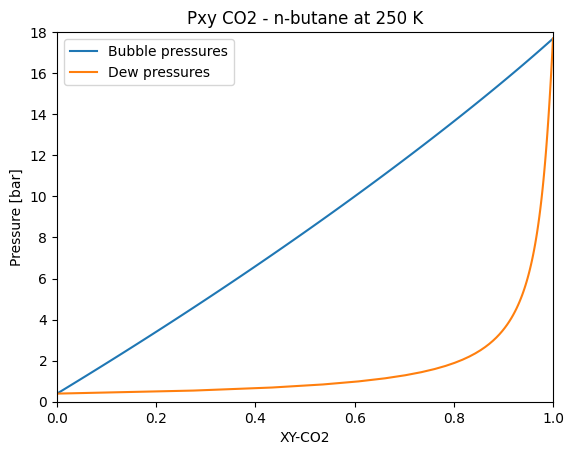

In [27]:
from yaeos import PengRobinson78
import matplotlib.pyplot as plt
import numpy as np

# Pure compounds properties
Tc = [304.2, 425.1]  # critical temperature of CO2 and n-butane [K]
Pc = [73.8, 38.0]  # critical pressure of CO2 and n-butane [bar]
w = [0.2236, 0.200164]  # acentric factor of CO2 and n-butane [-]


model = PengRobinson78(Tc, Pc, w)

# Mole compositions from 0 to 1 for CO2
z_co2 = np.linspace(0.0, 1.0, 100)
z_butane = 1.0 - z_co2

t = 250  # K

# storing bubble and dew points
bubble_point_z_co2 = z_co2
dew_point_z_co2 = []
pressures = []

for z in zip(z_co2, z_butane):
    sat_p = model.saturation_pressure(z=z, temperature=t, kind="bubble")

    dew_point_z_co2.append(sat_p["y"][0])
    pressures.append(sat_p["P"])


# Make diagram
plt.plot(bubble_point_z_co2, pressures, label="Bubble pressures")
plt.plot(dew_point_z_co2, pressures, label="Dew pressures")

plt.legend()
plt.title("Pxy CO2 - n-butane at 250 K")
plt.xlabel("XY-CO2")
plt.ylabel("Pressure [bar]")
plt.xlim(0, 1)
plt.ylim(0, 18)

## Flash calculation

Flash calculation are also supported by `yaeos`. Let's calculate a liquid-vapor
flash at 250 K for the CO2 and n-butane mixture.

In [39]:
# Pure compounds properties
n = [0.5, 0.5]  # mole number of CO2 and n-butane [mol]
Tc = [304.2, 425.1]  # critical temperature of CO2 and n-butane [K]
Pc = [73.8, 38.0]  # critical pressure of CO2 and n-butane [bar]
w = [0.2236, 0.200164]  # acentric factor of CO2 and n-butane [-]


model = PengRobinson78(Tc, Pc, w)

flash = model.flash_pt(z=[0.5, 0.5], pressure=4, temperature=250.0)

flash

 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     
 WARN: possible bad root solving:    6.9215890337653613E-310   4.0000000000000000     


{'x': array([0.23809283, 0.76190717]),
 'y': array([0.91415847, 0.08584153]),
 'Vx': 0.0772038243110709,
 'Vy': 4.959609854159413,
 'P': 4.0,
 'T': 250.0,
 'beta': 0.3873990240956161}

The result of the flash calculation is a Python dictionary with the same
information as the saturation pressure calculation. We can plot the results 
in the Pxy diagram that we created before.

(0.0, 18.0)

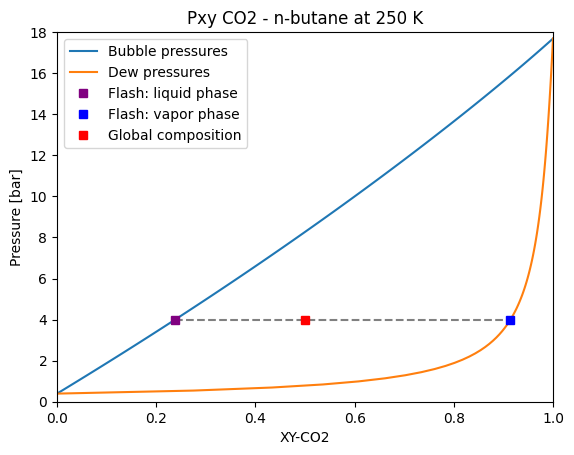

In [55]:
plt.plot(bubble_point_z_co2, pressures, label="Bubble pressures")
plt.plot(dew_point_z_co2, pressures, label="Dew pressures")

# Flash result plot
x = flash["x"][0]
y = flash["y"][0]
p = flash["P"]

# guide to the eye
plt.plot([x, y], [p, p], linestyle="--", color="gray")

# flash compositions
plt.plot(
    x,
    p,
    marker="s",
    linestyle="none",
    color="purple",
    label="Flash: liquid phase",
)
plt.plot(
    y,
    p,
    marker="s",
    linestyle="none",
    color="blue",
    label="Flash: vapor phase",
)

# global composition
plt.plot(
    0.5,
    p,
    marker="s",
    linestyle="none",
    color="red",
    label="Global composition",
)

# Pxy diagram
plt.legend()
plt.title("Pxy CO2 - n-butane at 250 K")
plt.xlabel("XY-CO2")
plt.ylabel("Pressure [bar]")
plt.xlim(0, 1)
plt.ylim(0, 18)

## PT phase envelope calculation

`yaeos` also provides a method to calculate the 2 phase envelope of a mixture.
Of course, we are going to keep using the CO2 and n-butane mixture, with a 
global composition [0.5, 0.5].

In [70]:
env = model.phase_envelope_pt(
    z=[0.5, 0.5], kind="bubble", max_points=600, t0=100.0, p0=4.0
)

Well, to make an envelope we have to specify a global composition `z`. The
`kind` of the saturation point to start the envelope calculation (use "bubble"
or "dew"). The `max_point` parameters could not be set (default 300), is the
maximum number of (P, T) points to calculate in the envelope. `t0` is the
initial guess for the temperature of the first saturation point of the envelope
of kind: `kind` ("bubble" in this case). And finally, `p0` is the initial guess
for the pressure of the first saturation point of the envelope of kind: `kind`.

The result of the envelope calculation is a Python dictionary with the keys:

In [71]:
env.keys()

dict_keys(['Ts', 'Ps', 'Tcs', 'Pcs'])

Being:

- Ts: temperature points of the phase envelope
- Ps: pressure points of the phase envelope
- Tcs: critical temperatures of the phase envelope
- Pcs: critical pressures of the phase envelope

We can plot the phase envelope as follow:

Text(0, 0.5, 'Pressure [bar]')

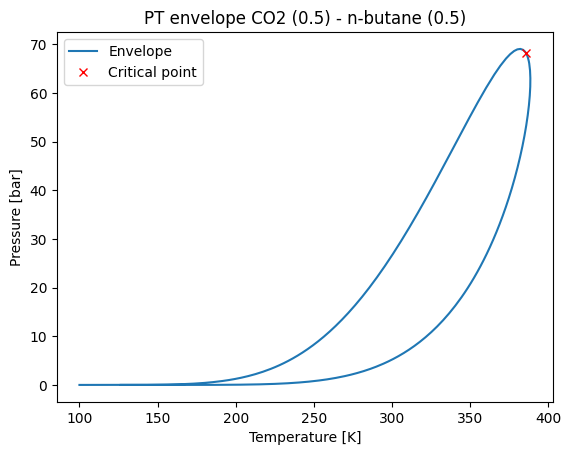

In [73]:
# envelope
plt.plot(env["Ts"], env["Ps"], label="Envelope")

# Critical point
plt.plot(
    env["Tcs"],
    env["Pcs"],
    marker="x",
    linestyle="none",
    color="red",
    label="Critical point",
)

plt.legend()
plt.title("PT envelope CO2 (0.5) - n-butane (0.5)")
plt.xlabel("Temperature [K]")
plt.ylabel("Pressure [bar]")